In [2]:
import re
import asyncio
import operator
from typing import List, Literal, TypedDict
from concurrent.futures import ThreadPoolExecutor

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import ToolNode
from decouple import config
from serpapi import GoogleSearch
from dotenv import load_dotenv
from youtube_transcript_api import YouTubeTranscriptApi

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.types import Send, Command
from langgraph.graph import END, START, StateGraph, MessagesState

load_dotenv()

SERPAPI_API_KEY = config("SERPAPI_API_KEY")
GROQ_API_KEY = config("GROQ_API_KEY")

MODEL_NAME = "llama-3.3-70b-versatile" #"qwen-qwq-32b"
MAX_TOKENS = 2000  # Adjust based on API limit

# Define rate limiter (6,000 TPM → ~100 requests per minute max)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=1.6,  # Ensures we stay within ~100 requests per minute
    check_every_n_seconds=0.1,
    max_bucket_size=10  # Allows for small bursts
)


llm = init_chat_model( 
    model=MODEL_NAME, 
    model_provider="groq",
    temperature=0.4,
    api_key=GROQ_API_KEY,
    rate_limiter=rate_limiter
)




In [25]:
# Create tools

@tool
async def search_youtube_video(title: str):
    """
    Search for a YouTube video based on a given title.

    Use this tool when you need to find a relevant YouTube video before retrieving its transcript.
    This tool returns the title, video link, and video ID, which can then be used for fetching the transcript.

    Input:
    - title: The search query for the YouTube video.

    Output:
    - A dictionary with:
      - 'title': The video title.
      - 'link': The direct URL to the video.
      - 'video_id': The unique YouTube video ID for transcript retrieval.
    """
    params = {
        "engine": "youtube",
        "search_query": title,
        "api_key": SERPAPI_API_KEY
    }
    search = GoogleSearch(params)
    
    # Run search in an async-compatible way
    results = await run_in_executor(search.get_dict)

    if "video_results" in results:
        video = results["video_results"][0]  # Get the first result
        return {
            "title": video["title"],
            "link": video["link"],
            "video_id": video["link"].split("v=")[-1]
        }
    return None


@tool
async def get_youtube_transcript(video_id: str):
    """
    Asynchronously fetch the transcript for a YouTube video.
    
    Use this tool when you have a video_id and need to retrieve the full transcript.
    The returned transcript may be very long and should be processed further.
    
    Input:
    - video_id: The unique identifier for the YouTube video.
    
    Output:
    - A string containing the full transcript.
    """
    try:
        transcript = await run_in_executor(lambda: YouTubeTranscriptApi.get_transcript(video_id))
        return " ".join([t["text"] for t in transcript])
    except Exception as e:
        return f"Transcript not available: {e}"


@tool
def chunk_transcript(text: str, chunk_size: int = 2000):
    """
    Splits long transcripts into smaller chunks for processing.
    
    Use this tool after retrieving a transcript that is too long to handle in one go.
    This tool breaks the transcript into chunks of at most chunk_size characters.
    
    Input:
    - text: The full transcript.
    - chunk_size: Maximum characters per chunk (default 2000).
    
    Output:
    - A list of transcript chunks.
    """
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=200
    )
    return splitter.split_text(text)



tools = [search_youtube_video, get_youtube_transcript, chunk_transcript]
tool_node = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

# Async-compatible executor for blocking operations
executor = ThreadPoolExecutor()

def run_in_executor(func, *args):
    """Helper function to run blocking tasks asynchronously."""
    loop = asyncio.get_running_loop()
    return loop.run_in_executor(executor, func, *args)


# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm_with_tools | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm_with_tools | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
# Define our state type (including the user's query, transcript chunks, summary, and index)
class State(MessagesState):
    transcript: str       # The full transcript from get_youtube_transcript
    contents: List[str]   # Transcript chunks (to be populated by chunk_transcript)
    index: int            # Current index for summarization
    summary: str          # Accumulated summary


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"

# --- Tool-Calling Phase Nodes ---
# This node calls the LLM, which might output a tool call (e.g. call get_youtube_transcript)
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)  # LLM may include tool_calls if a tool is needed
    return {"messages": [response]}

def should_continue(state: State) -> Literal["tools", "generate_initial_summary", END]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there's an outstanding tool call, let the tools node process it.
    if last_message.tool_calls:
        return "tools"
    # If transcript exists but we haven't chunked it yet, prompt the LLM to call chunk_transcript.
    elif state["transcript"] and not state["contents"]:
        return "tools"
    # Once transcript chunks exist, move to summarization.
    elif state["contents"]:
        return "generate_initial_summary"
    return END


In [26]:
# --- Graph Arrangement ---

graph = StateGraph(State)

# Tool-calling part: to sequentially invoke the YouTube tools if needed.
# Add nodes.
graph.add_node("agent", call_model)
graph.add_node("tools", tool_node)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

# Arrange edges for the tool-calling phase.
graph.add_edge(START, "agent")
graph.add_conditional_edges("agent", should_continue, {
    "tools": "tools",                     # If tool calls exist.
    "generate_initial_summary": "generate_initial_summary",  # If transcript chunks are available.
    END: END                              # Otherwise, end the workflow.
})
graph.add_edge("tools", "agent")  # After executing tools, return to the agent.

# Arrange edges for the summarization phase.
graph.add_conditional_edges("generate_initial_summary", should_refine, {
    "refine_summary": "refine_summary",
    END: END
})
graph.add_conditional_edges("refine_summary", should_refine, {
    "refine_summary": "refine_summary",
    END: END
})

# Compile the graph.
app = graph.compile()

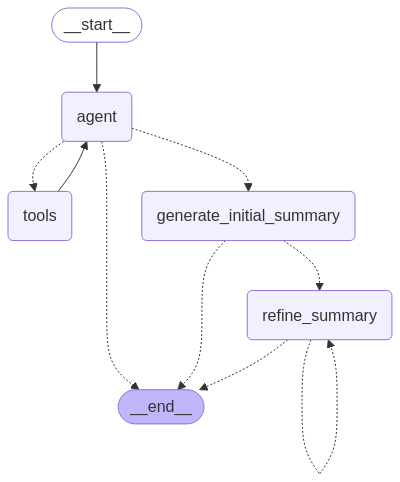

In [27]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [28]:
query = "Love in Every Word (Odogwu Paranra) by Omoni Oboli"

# Run the workflow
async for chunk in app.astream(
    {"messages": [("human", query)]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

Love in Every Word (Odogwu Paranra) by Omoni Oboli
================================== Ai Message ==================================
Tool Calls:
  search_youtube_video (call_egng)
 Call ID: call_egng
  Args:
    title: Love in Every Word (Odogwu Paranra) by Omoni Oboli
================================= Tool Message =================================
Name: search_youtube_video

{"title": "LOVE IN EVERY WORD - Nigerian Movies 2025 Latest Full Movies", "link": "https://www.youtube.com/watch?v=bslcx4LRFL0", "video_id": "bslcx4LRFL0"}
================================== Ai Message ==================================
Tool Calls:
  get_youtube_transcript (call_z1zg)
 Call ID: call_z1zg
  Args:
    video_id: bslcx4LRFL0
================================= Tool Message =================================
Name: get_youtube_transcript

all I'm asking for is $2,000 you and I know $2,000 is not really it's not a big deal you 

APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `llama-3.3-70b-versatile` in organization `org_01jmyj4qz1ek0sb7ehk09n36a8` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 14764, please reduce your message size and try again. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

I think implementing the concepts here would help resolve the APIStatusError:  https://langchain-ai.github.io/langgraph/how-tos/update-state-from-tools/#define-tool